In [1]:
import numpy as np
import pandas as pd
import glob
import os
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.table import Table
import itertools
from astroquery.simbad import Simbad
from utils import PLOT_PARAMS
from astropy import constants as const
from matplotlib import colors
PLOT_PARAMS()
import thejoker as tj

from datetime import date
today=date.today()
DATE =today.strftime("%m_%d_%y")
print(DATE)
import pickle
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors

plt.rcParams['figure.facecolor'] = 'white'
import warnings
warnings.filterwarnings("ignore")
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u

vlt = EarthLocation.of_site('paranal')  # the easiest way... but requires internet

06_27_25


In [42]:
rv_df  = pd.read_csv('comb_rvs.csv')
table4 = pd.read_csv('table4.csv')

In [3]:
binary_list_113 = 1, 4, 5, 7, 9, 11, 16, 18, 19, 21, 23  
binary_list_112 = 5, 6, 7, 13, 23

In [6]:
galah = Table.read('../../lithium/data/GALAH_DR3_main_allstar_v2.fits').to_pandas()

In [41]:
rv_df.keys()

Index(['sobject_id', 'logg', 'teff', 'RG_id', 'galah_id', 'obj_name',
       'esp_time', 'esp_rv', 'esp_rv_err', 'Li_val', 'e_Li_val', 'vbroad',
       'e_vbroad', 'fe_h', 'ruwe_dr2', 'Ba_fe', 'e_Ba_fe', 'La_fe', 'e_La_fe',
       'Zr_fe', 'e_Zr_fe', 'Y_fe', 'e_Y_fe', 'program', 'ra_dr2', 'dec_dr2',
       'dr3_source_id', 'MJD_local', 'rv_nogr_obst', 'e_rv_nogr_obst',
       'rv_galah', 'e_rv_galah', 'comb_time', 'comb_rv', 'comb_rv_err'],
      dtype='object')

In [120]:
abundances = []
abundance_err = []
for c in galah.keys():
    if '_fe' in c and 'flag_' not in c and 'nr' not in c and 'e_' not in c: 
        abundances.append(c)
        abundance_err.append('e_'+c)

16 18
A:	 N1 	 N2
alpha_fe 18 	 16
O_fe 	 16 	 14
Na_fe 	 18 	 16
Mg_fe 	 18 	 16
Al_fe 	 18 	 15
Si_fe 	 18 	 16
K_fe
K_fe 	 18 	 16
Ca_fe 	 16 	 15
Sc_fe 	 18 	 16
Ti_fe 	 18 	 15
Ti2_fe 	 17 	 11
V_fe 	 11 	 6
Cr_fe 	 18 	 16
Mn_fe 	 18 	 15
Co_fe 	 18 	 14
Ni_fe 	 18 	 15
Cu_fe 	 18 	 14
Zn_fe 	 16 	 13
Sr_fe 	 7 	 6
Y_fe 	 16 	 14
Zr_fe
Zr_fe 	 13 	 8
Ba_fe 	 18 	 16
La_fe 	 17 	 10
Nd_fe 	 14 	 13
Sm_fe 	 14 	 8
Eu_fe 	 16 	 13


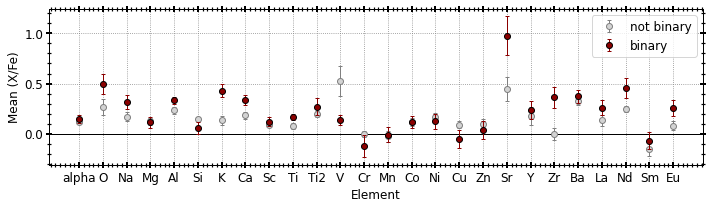

In [193]:
def get_abs(abundances):
    PLOT_PARAMS(LS=12, SIZE=12)
    binary = rv_df[rv_df.sobject_id.isin(table4.sobject_id)]
    notbin = rv_df[~rv_df.sobject_id.isin(table4.sobject_id)]
    print(len(binary),len(notbin))

    # C, Cr2, Sc2 were removed b/c of NaN values
    # Li was removed b/c it was too large and I wanted to perserve the scale
    # Ru, Rb and Mo were removed b/c of insufficient data points
    abundances = [a for a in abundances if a not in ['Li_fe','C_fe','Cr2_fe','Sc2_fe', 'Ru_fe', 'Rb_fe', 'Mo_fe']]
    abundance_err = [a for a in abundances if a not in ['e_Li_fe','e_C_fe','e_Cr2_fe','e_Sc2_fe', 'e_Ru_fe', 'e_Rb_fe', 'e_Mo_fe']]
    # binary first
    d   = []
    d_e = []
    for i, row in binary.iterrows():
        sobject_id   = row.sobject_id
        ab_per_star  = galah[galah.sobject_id==sobject_id][abundances].values[0]
        err_per_star = galah[galah.sobject_id==sobject_id][abundance_err].values[0]
        ab_names     = [a[:-3] for a in abundances if '_fe' in a]
        d.append(ab_per_star)
        d_e.append(err_per_star)
        
    binary_d   = pd.DataFrame(d, columns=abundances)
    binary_err = pd.DataFrame(d_e, columns=abundances)
    
    # not binary next
    d   = []
    d_e = []
    for i, row in notbin.iterrows():
        sobject_id   = row.sobject_id
        ab_per_star  = galah[galah.sobject_id==sobject_id][abundances].values[0]
        err_per_star = galah[galah.sobject_id==sobject_id][abundance_err].values[0]
        ab_names     = [a[:-3] for a in abundances if '_fe' in a]
        d.append(ab_per_star)
        d_e.append(err_per_star)
        
    notbin_d   = pd.DataFrame(d, columns=abundances)
    notbin_err = pd.DataFrame(d_e, columns=abundances)
    
    # plotting
    plt.figure(figsize=(10,3))
    ax = plt.subplot(111)
    for i,a in enumerate(abundances):
        N1         = notbin_d[a].count()
        err_notbin = np.std(notbin_d[a])/np.sqrt(N1)
        
        N2         = binary_d[a].count()
        err_binary = np.std(binary_d[a])/np.sqrt(N2)
        
        plt.errorbar(i, np.mean(notbin_d[a]), yerr=err_notbin, fmt='o', label='not binary', capsize=2,lw=1, color='lightgrey',mec='grey',ecolor='grey')
        plt.errorbar(i, np.mean(binary_d[a]), yerr=err_binary, fmt='o', label='binary',capsize=2,lw=1, color='darkred',mec='k',zorder=100)
        if i==0: plt.legend()
            
        # calculate 3-sigma difference:
        D       = abs(np.mean(notbin_d[a]) - np.mean(binary_d[a]))
        sigma_D = np.sqrt(err_notbin**2 + err_binary**2)
        if (D/sigma_D) >= 3: print(a)
        if i ==0: 
            print('A:\t N1 \t N2',)
            print(a,N1,'\t', N2)
        else:
            print(a, '\t',N1,'\t', N2)
    xlabels = [x[0:-3] for x in abundances]
    ax.set_xticks(np.arange(len(xlabels)))
    ax.set_xticklabels(xlabels)
    
    plt.grid(ls='dotted',c='grey')
    plt.ylabel('Mean (X/Fe)')
    plt.xlabel('Element')
    plt.axhline(0, c='k', lw=1)
    plt.tight_layout()
    plt.savefig('../plots/abundance_%s.png'%DATE,bbox_inches='tight',dpi=150)

    plt.show()

get_abs(abundances)


26


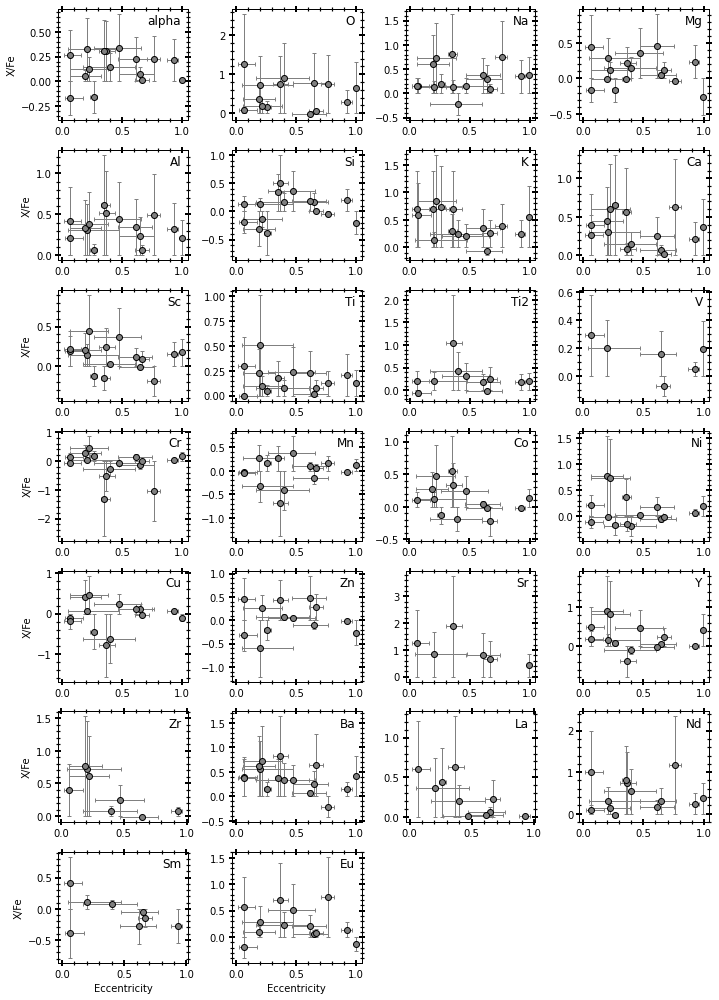

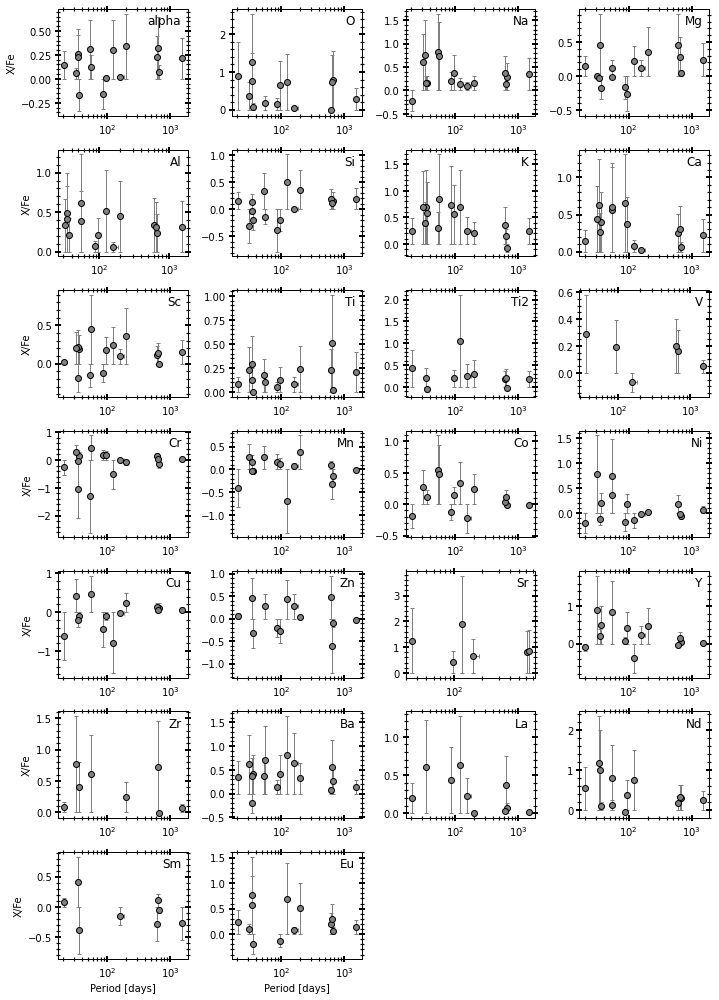

In [204]:
def abs_ecc(abundances):
    PLOT_PARAMS(LS=10, SIZE=10)
    binary = rv_df[rv_df.sobject_id.isin(table4.sobject_id)]
    
    # C, Cr2, Sc2 were removed b/c of NaN values
    # Li was removed b/c it was too large and I wanted to perserve the scale
    # Ru, Rb and Mo were removed b/c of insufficient data points
    abundances = [a for a in abundances if a not in ['Li_fe','C_fe','Cr2_fe','Sc2_fe', 'Ru_fe', 'Rb_fe', 'Mo_fe']]
    abundance_err = [a for a in abundances if a not in ['e_Li_fe','e_C_fe','e_Cr2_fe','e_Sc2_fe', 'e_Ru_fe', 'e_Rb_fe', 'e_Mo_fe']]
    
    d, d_e = [], []
    ecc, e16, e84 = [], [], []
    per, p16, p84 = [], [], []
    
    for i, row in binary.iterrows():
        sobject_id   = row.sobject_id
        ab_per_star  = galah[galah.sobject_id==sobject_id][abundances].values[0]
        err_per_star = galah[galah.sobject_id==sobject_id][abundance_err].values[0]
        ab_names     = [a[:-3] for a in abundances if '_fe' in a]
        e            = table4[table4.sobject_id==sobject_id].e50.values[0]
        e1           = table4[table4.sobject_id==sobject_id].e16.values[0]
        e2           = table4[table4.sobject_id==sobject_id].e84.values[0]
        p            = table4[table4.sobject_id==sobject_id].P50.values[0]
        p1           = table4[table4.sobject_id==sobject_id].P16.values[0]
        p2           = table4[table4.sobject_id==sobject_id].P84.values[0]
        
        d.append(ab_per_star)
        d_e.append(err_per_star)
        ecc.append(e)
        e16.append(e1)
        e84.append(e2)
        per.append(p)
        p16.append(p1)
        p84.append(p2)
        
    
    d   = pd.DataFrame(d, columns=abundances)
    d_err = pd.DataFrame(d_e, columns=abundances)
    
    d['e50'] = ecc
    d['e16'] = e16
    d['e84'] = e84
    d['p50'] = per
    d['p16'] = p16
    d['p84'] = p84
    
    print(len(abundances))
    
    plt.figure(figsize=(10,14))
    
    for i,a in enumerate(abundances):
        ax=plt.subplot(7,4,i+1)

        x1 = (d.e50-d.e16).values
        x2 = (d.e84-d.e50).values
        
        plt.errorbar(d.e50, d[a], xerr= [x1, x2], yerr=abs(d_err[a]), fmt='o', mec='k', color='grey',lw=1,capsize=2)
        ax.text(0.95, 0.95, a[:-3], transform=ax.transAxes,fontsize=12, ha='right', va='top')
        
        if i % 4 == 0: plt.ylabel('X/Fe')
        if i + 1 > 24: plt.xlabel('Eccentricity')
        
    plt.tight_layout()
    plt.savefig('../plots/abundance_vs_ecc_%s.png'%DATE,bbox_inches='tight',dpi=150)
    
    plt.figure(figsize=(10,14))
    for i,a in enumerate(abundances):
        ax=plt.subplot(7,4,i+1)

        x1 = (d.p50-d.p16).values
        x2 = (d.p84-d.p50).values
        
        plt.errorbar(d.p50, d[a], xerr= [x1, x2], yerr=abs(d_err[a]), fmt='o', mec='k', color='grey',lw=1,capsize=2)
        plt.xscale('log')
        ax.text(0.95, 0.95, a[:-3], transform=ax.transAxes,fontsize=12, ha='right', va='top')
        
        if i % 4 == 0: plt.ylabel('X/Fe')
        if i + 1 > 24: plt.xlabel('Period [days]')
            
    plt.tight_layout()
    plt.savefig('../plots/abundance_vs_per_%s.png'%DATE,bbox_inches='tight',dpi=150)
    
abs_ecc(abundances) 

In [199]:
0 % 4

0